In [1]:
!pip install tensorflow numpy matplotlib scikit-learn medpy nibabel SimpleITK

In [2]:
!pip install nibabel

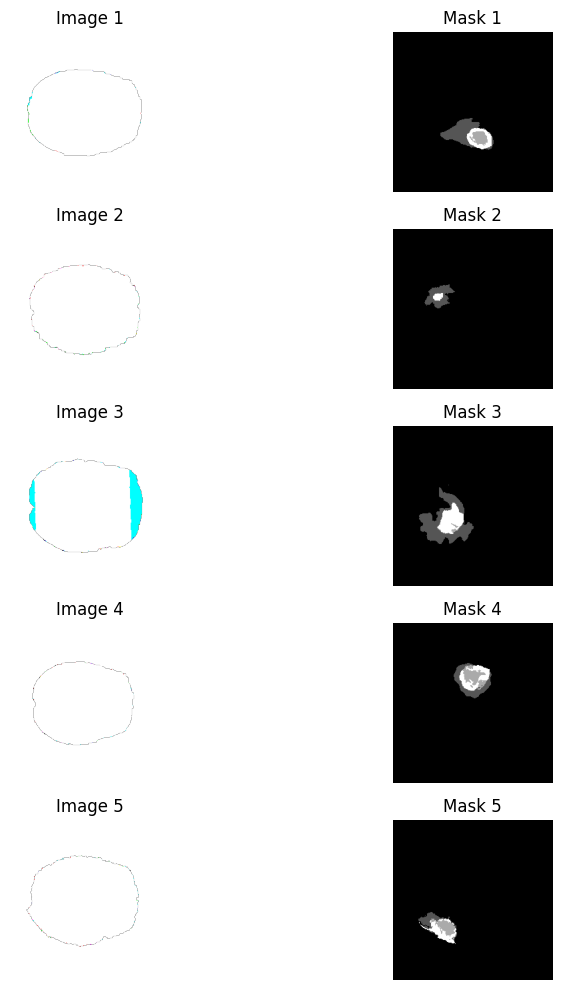

In [3]:
import nibabel as nib
import matplotlib.pyplot as plt
import os

def load_nifti_file(filepath):
    # Load the .nii.gz file
    nii_image = nib.load(filepath)
    return nii_image.get_fdata()

def display_images_with_masks(image_files, mask_files, num_images=5):
    plt.figure(figsize=(10, 10))

    for i in range(num_images):
        image = load_nifti_file(image_files[i])
        mask = load_nifti_file(mask_files[i])

        middle_slice_index = image.shape[2] // 2
        plt.subplot(num_images, 2, 2*i+1)
        plt.imshow(image[:, :, middle_slice_index], cmap='gray')
        plt.title(f'Image {i+1}')
        plt.axis('off')

        plt.subplot(num_images, 2, 2*i+2)
        plt.imshow(mask[:, :, middle_slice_index], cmap='gray')
        plt.title(f'Mask {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

image_folder = '/content/drive/MyDrive/Task01_BrainTumour/imagesTr'
mask_folder = '/content/drive/MyDrive/Task01_BrainTumour/labelsTr'

image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.nii.gz')])
mask_files = sorted([os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.endswith('.nii.gz')])

display_images_with_masks(image_files, mask_files, num_images=5)


In [1]:
import os
import nibabel as nib
import numpy as np

def load_nifti_file(file_path):
    nii_image = nib.load(file_path)
    return nii_image.get_fdata()

def load_data(directory):
    images = []
    masks = []
    files = sorted([f for f in os.listdir(directory) if f.endswith('.nii.gz')])
    for file in files:
        data = load_nifti_file(os.path.join(directory, file))
        for i in range(data.shape[2]):
            images.append(data[:, :, i])
    return np.array(images, dtype=np.float32)

image_directory = '/content/drive/MyDrive/Task01_BrainTumour/imagesTr'
mask_directory = '/content/drive/MyDrive/Task01_BrainTumour/labelsTr'

images = load_data(image_directory)
masks = load_data(mask_directory)

In [4]:
import os
from tensorflow.keras.models import load_model
from sklearn.model_selection import KFold
from medpy.metric import binary
import numpy as np

#def dice_coefficient(y_true, y_pred):
 #   intersection = np.sum(y_true * y_pred)
  #  return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

def dice_coefficient(y_true, y_pred):
    if y_pred.ndim > y_true.ndim:
        y_pred = np.squeeze(y_pred, axis=-1)

    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))


def hausdorff_distance_safe(y_true, y_pred):
    if np.count_nonzero(y_true) == 0 or np.count_nonzero(y_pred) == 0:
        return np.nan
    else:
        return binary.hd95(y_true, y_pred)

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Activation
from tensorflow.keras.optimizers import Adam

def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)

    # Decoder
    u1 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c3)
    m1 = concatenate([u1, c2])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(m1)
    u2 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c4)
    m2 = concatenate([u2, c1])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(m2)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [3]:
from sklearn.model_selection import KFold
import numpy as np
import cv2

def preprocess_data(data, new_size=(256, 256), is_mask=False):
    processed_data = []
    for img in data:
        if img.ndim == 3 and img.shape[2] > 1 and not is_mask:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        elif img.ndim == 2 or (img.ndim == 3 and img.shape[2] == 1):
            img = img.squeeze()
        img_resized = cv2.resize(img, new_size, interpolation=cv2.INTER_CUBIC)
        img_resized = img_resized[..., np.newaxis]
        processed_data.append(img_resized)
    return np.array(processed_data)

images = preprocess_data(images, new_size=(256, 256), is_mask=False)
masks = preprocess_data(masks, new_size=(256, 256), is_mask=True)

print("Preprocessed training images shape:", images.shape)
print("Preprocessed masks shape:", masks.shape)


Preprocessed training images shape: (75020, 256, 256, 1)
Preprocessed masks shape: (75020, 256, 256, 1)


In [5]:
kf = KFold(n_splits=5)
results = []

for train_idx, val_idx in kf.split(images):
    train_images, train_masks = images[train_idx], masks[train_idx]
    val_images, val_masks = images[val_idx], masks[val_idx]

    model = unet_model(input_size=(256, 256, 1))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(train_images, train_masks, batch_size=1, epochs=1, validation_data=(val_images, val_masks))

    model_save_path = f'/content/drive/MyDrive/Task01_BrainTumour/unet_model_fold_{train_idx + 1}.h5'
    model.save(model_save_path)
    print(f"Model saved at {model_save_path}")

    val_preds = model.predict(val_images)

    val_preds = (val_preds > 0.5).astype(np.uint8)

    if val_masks.ndim > 2:
        val_masks = val_masks.squeeze()

    dice = dice_coefficient(val_masks.squeeze(), val_preds.squeeze())
    hausdorff = hausdorff_distance_safe(val_masks.squeeze(), val_preds.squeeze())

    results.append({'dice': dice, 'hausdorff': hausdorff})
    print(f"Dice Score: {dice}, Hausdorff Distance: {hausdorff}")


37510/37510 [==============================] - 7819s 208ms/step - loss: -0.1172 - accuracy: 0.9813 - val_loss: -6.8522e-04 - val_accuracy: 0.9846


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved at /content/drive/MyDrive/Task01_BrainTumour/unet_model_fold_[37511 37512 37513 ... 75018 75019 75020].h5
1173/1173 [==============================] - 691s 588ms/step
Dice Score: 0.02603529114830152, Hausdorff Distance: 27.16615541441225
37510/37510 [==============================] - 7844s 209ms/step - loss: -0.1402 - accuracy: 0.9785 - val_loss: -1.3657 - val_accuracy: 0.9858
Model saved at /content/drive/MyDrive/Task01_BrainTumour/unet_model_fold_[    1     2     3 ... 37508 37509 37510].h5
1173/1173 [==============================] - 693s 591ms/step
Dice Score: 0.0, Hausdorff Distance: 11672.102263517056


In [6]:
avg_dice = np.mean([r['dice'] for r in results])
avg_hausdorff = np.mean([r['hausdorff'] for r in results if r['hausdorff'] is not np.nan])

print(f"Average Dice Coefficient: {avg_dice}")
print(f"Average Hausdorff Distance: {avg_hausdorff}")


Average Dice Coefficient: 0.01301764557415076
Average Hausdorff Distance: 5849.634209465734


1/1 [==============================] - 0s 95ms/step


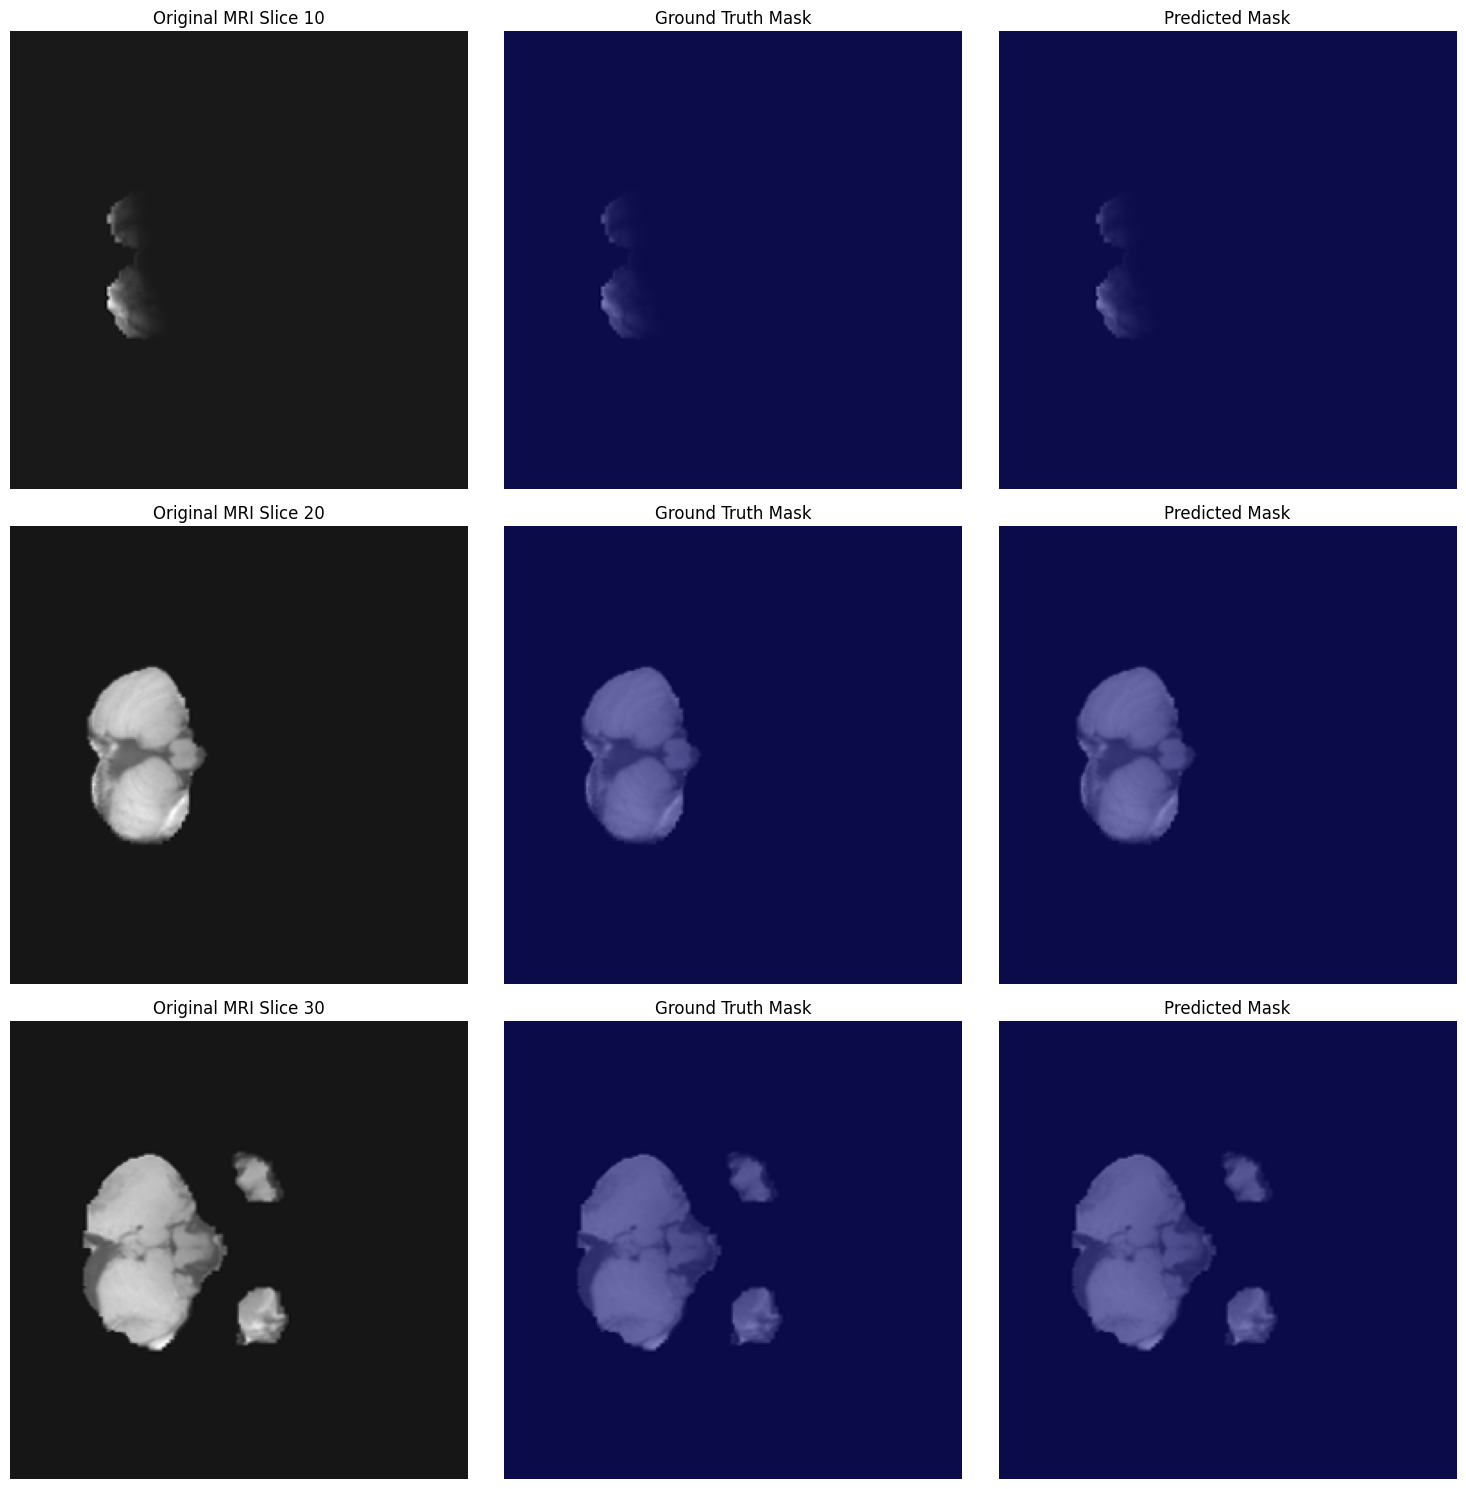

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_segmentation(slices, images, true_masks, predicted_masks):
    num_slices = len(slices)
    fig, axes = plt.subplots(num_slices, 3, figsize=(15, 5 * num_slices))

    for i, slice_num in enumerate(slices):
        image = images[slice_num, ..., 0]
        true_mask = true_masks[slice_num]
        pred_mask = predicted_masks[i]

        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title(f'Original MRI Slice {slice_num}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(image, cmap='gray')
        axes[i, 1].imshow(np.isin(true_mask, [1, 2, 4]), cmap='jet', alpha=0.5)
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(image, cmap='gray')
        axes[i, 2].imshow(np.isin(pred_mask, [1, 2, 4]), cmap='jet', alpha=0.5)
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

slices = [10, 20, 30]
predicted_masks = model.predict(images[slices])[..., 0] > 0.5
visualize_segmentation(slices, images, masks, predicted_masks)
